# Neural Machine Transalation with Attention and Teacher Forcing by Keras

In [40]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, Dense, Embedding
from keras.layers import RepeatVector, Dot, Concatenate, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_samples = 10000
max_sequence_length = 100
max_num_words = 20000

In [3]:
def load_data(file_name):
    t = 0
    input_texts = []
    target_texts = []
    target_texts_inputs = []
    with open(file_name,  'r') as f:
        for line in f:
            t+=1
            if t > num_samples:
                break

            if '\t' not in line:
                continue

            input_text, translation = line.rstrip().split('\t')


            translation = translation.strip('\n')

            target_text = translation + ' E'
            target_text_input = 'S ' + translation

            input_texts.append(input_text)
            target_texts.append(target_text)
            target_texts_inputs.append(target_text_input)
    return input_texts, target_texts, target_texts_inputs

In [4]:
input_texts, target_texts, target_texts_inputs = load_data("data/cmn.txt")

print(len(input_texts))
print(len(target_texts))
print(len(target_texts_inputs))

10000
10000
10000


### Tokenize the inputs

In [6]:
tokenizer_inputs = Tokenizer(num_words=max_num_words)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [7]:
max_len_input = max(len(s) for s in input_sequences)
print('max_len_input:', max_len_input)

max_len_input: 9


In [8]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found {0} unique input token'.format(len(word2idx_inputs)))

Found 3570 unique input token


### Tokenize the outputs

In [10]:
# NOTE:
# The char_level is set to True, because we tokenize chinese character 
tokenizer_outputs = Tokenizer(num_words=max_num_words, filters='', char_level = True)
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [11]:
word2idx_outputs = tokenizer_outputs.word_index
print('Found {0} unique input token'.format(len(word2idx_outputs)))

Found 2629 unique input token


In [12]:
assert('S' in word2idx_outputs)
assert('E' in word2idx_outputs)

In [13]:
max_len_target = max(len(s) for s in target_sequences)
print('max_len_target:', max_len_target)

max_len_target: 22


In [14]:
print(len(target_sequences[9999]))

11


In [15]:
print(len(input_texts))
print(len(target_texts))
target_texts[:20]

10000
10000


['嗨。 E',
 '你好。 E',
 '你用跑的。 E',
 '等等！ E',
 '你好。 E',
 '让我来。 E',
 '我赢了。 E',
 '不会吧。 E',
 '乾杯! E',
 '他跑了。 E',
 '跳进来。 E',
 '我迷失了。 E',
 '我退出。 E',
 '我沒事。 E',
 '听着。 E',
 '不可能！ E',
 '没门！ E',
 '你确定？ E',
 '试试吧。 E',
 '我们来试试。 E']

### Padding

In [16]:
encode_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
decode_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
decode_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

### Prepare embedding matrix and embedding layer

In [17]:
def load_word2vec(file_name):
    word2vec = {}
    with open(file_name, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vec = np.array(values[1:], dtype=np.float32)
            word2vec[word] = vec
    return word2vec

In [18]:
word2vec = load_word2vec('data/glove.6B.50d.txt')

### One hot targets

In [134]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [135]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decode_targets_one_hot = np.zeros(
  (
    len(target_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decode_targets):
    for t, word in enumerate(d):
        decode_targets_one_hot[i, t, word] = 1

## 2. Construct Training Model

### 2.1 Encoder 

**Embedding layer**

In [ ]:
embedding_dim = 50
num_words = min(max_num_words + 1, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, index in word2idx_inputs.items():
    if index <= max_num_words:
        vector = word2vec.get(word)
        if vector is not None:
            embedding_matrix[index] = vector

In [ ]:
embedding_layer = Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    weights = [embedding_matrix],
    input_length = max_len_input,
    name='encoder_embed'
)

In [136]:
latent_dim = 192

In [137]:
# Take input sequences as input
encoder_inputs_placeholder = Input(shape=(max_len_input,), name='encoder_inputs')
encoder_inputs_x = embedding_layer(encoder_inputs_placeholder)

print('encoder inputs after embedding:', encoder_inputs_x.shape)

# IMPORTANT: 
# Because we are using Attention, we do not need final hidden state. Instead, we need the outputs 
# (i.e., hidden states) from all time steps and pass those hidden states to decoder to generate context vector.
# Therefore:
# 1. The return_state is set to False (default), because we do not pass final hidden state to decoder 
#    and thus we do not need to control state.
# 2. The return_sequences is set to True, because we use Attention, we need the outputs from all time steps
encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, dropout=0.5), name='encoder_bidirectional_lstm')

# Only outputs returned and will be passed to attention layer to compute attention weights
encoder_lstm_outputs = encoder_lstm(encoder_inputs_x)

print('encoder LSTM outputs:', encoder_lstm_outputs.shape)

encoder inputs after embedding: (?, 9, 50)
encoder LSTM outputs: (?, ?, 384)


### 2.2 Decoder 

In [138]:
# Take input from target sequence for Teacher Forcing
decoder_inputs_placeholder = Input(shape=(max_len_target,), name='decoder_inputs')

# We need inputs for initializing hidden state and cell state of decoder LSTM, this is because:
#   1. We will not pass last time step state from encoder to decoder (as initial value), 
#      as we do when no attention used.
#   2. We have to control the flow of states through time in decoder LSTM because we need to compute 
#      context vector manually (meaning coding by ourselves) at each time step.
s0 = Input(shape=(latent_dim,), name='decoder_s_initial')
c0 = Input(shape=(latent_dim,), name='decoder_c_initial')

# Use different embedding from that of encoder
decoder_embedding = Embedding(num_words_output, embedding_dim, name='decoder_embed')
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

print('decoder inputs after embedding:', decoder_inputs_x.shape)

decoder inputs after embedding: (?, 22, 50)


> We use `decoder_inputs_x` for teacher forcing. But different from decoder without attention, we will not put `decoder_inputs_x` directly into LSTM layer. Instead, at each time step k, we will fetch $kth$ word vector from `decoder_inputs_x` (along the time step dimension) and concatenate it with `context vector` computed at time step $k$ and then feed the concatenated vector into the decoder LSTM.

In [221]:
# We do not set return_sequences to True since we will manually (meaning coding by ourselves) 
# roll-out decoder LSTM for computing context vector at eath time step.
decoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.5, name='decoder_lstm')
decoder_dense = Dense(num_words_output, activation='softmax', name='decoder_dense')

### 2.3 Attention

In [140]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

<img src='../images/attention_computation.png' style="width:500px;height:500px;"/>

In [141]:
attn_repeat_layer = RepeatVector(max_len_input, name='attn_repeat_layer')
attn_concat_layer = Concatenate(axis=-1, name='attn_concat_layer')
attn_dense1 = Dense(10, activation='tanh', name='attn_weights_dense_1')
attn_dense2 = Dense(1, activation=softmax_over_time, name='attn_weights_dense_2')
attn_dot = Dot(axes=1,name='attn_dot_layer')

In [142]:
def one_time_step_attention(h, s_t_1):
    
    s_t_1 = attn_repeat_layer(s_t_1)
    
    x = attn_concat_layer([h, s_t_1])
    
    x = attn_dense1(x)
    
    alphas = attn_dense2(x) 
    
    context = attn_dot([alphas, h])
    
    return context

In [143]:
# concatenate context and target word at time t
# the result is the input to decoder LSTM
context_last_word_concat_layer = Concatenate(axis=2, name='contxt_concat_layer')

# use to select a single word from decoder input sequence (after embedding) at time t
selector = Lambda(lambda x: x[:, t:t+1], name='decoder_inputs_x_selector')

We will use a for-loop to perform the computation at each time step and following picture shows the whole view of the decoder-attention layer:

<img src='../images/decoder_attention_all_steps.png' style="width:600px;height:400px;"/>

In [144]:
s = s0
c = c0
outputs = []
for t in range(max_len_target):
    
    # encoder_lstm_outputs is the hiddens states of all time steps from encoder, used to compute attention weights
    # s is the hidden state from previous time step of the decoder LSTM
    context = one_time_step_attention(encoder_lstm_outputs, s)
    
    # Select word vector at time step t from decoder_input_x, which is the target sequence (after embedding)
    xt = selector(decoder_inputs_x)
    
    # Concatenate context vector with target word vector
    decoder_lstm_input = context_last_word_concat_layer([context, xt])
    
    # Compute the output, hidden state and cell state for current LSTM time step
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])
    
    if t == 1:
        print('o shape:', o.shape)
        print('s shape:', o.shape)
        print('c shape:', o.shape)
    
    # Calculate probability distribution over all words of the vocabulary
    decoder_output = decoder_dense(o)
    
    # store current probability distribution in a list
    outputs.append(decoder_output)

### 2.4 Final outputs shape issue:
* `outputs` is now a list of length $T_y$, which is the target sequence length.
* Each element is of shape `(batch size, output vocab size)`
* Therefore if we simply stack all the outputs into 1 tensor, it would be of shape $T_y \times N \times D$
    * $N$ is `batch size` and $D$ is ` output vocab size`
* We would like it to be of shape $N \times T_y \times D$

In [145]:
def stack_and_transpose(x):
    # x is a list of length Ty, each element is a (batch_size, output_vocab_size) tensor
    x = K.stack(x) # is now (Ty, batch_size, output_vocab_size) tensor
    x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now (batch_size, Ty, output_vocab_size)
    return x

In [146]:
# make it a layer
stacker = Lambda(stack_and_transpose, name='decoder_outputs_tranposer')
outputs = stacker(outputs)
print(outputs.shape)

(?, 22, 2630)


### 3.5 Put pieces together

In [147]:
# encoder-decoder with attention model
encoder_decoder_attention_model = Model(inputs=[encoder_inputs_placeholder, 
                                                decoder_inputs_placeholder, 
                                                s0, c0], 
                                        outputs=outputs)

encoder_decoder_attention_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 9)            0                                            
__________________________________________________________________________________________________
encoder_embed (Embedding)       (None, 9, 50)        178550      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_s_initial (InputLayer)  (None, 192)          0                                            
__________________________________________________________________________________________________
encoder_bidirectional_lstm (Bid (None, 9, 384)       373248      encoder_embed[0][0]              
__________________________________________________________________________________________________
attn_repea

## 4. Train the Model

In [148]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [149]:
batch_size = 256
epochs = 120

z = np.zeros((num_samples, latent_dim)) # initial [s, c]
r = encoder_decoder_attention_model.fit([encode_inputs, decode_inputs, z, z], decode_targets_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/120
9000/9000 [==============================] - 192s 21ms/step - loss: 3.3945 - acc: 0.5353 - val_loss: 3.3989 - val_acc: 0.4757
Epoch 2/120
9000/9000 [==============================] - 154s 17ms/step - loss: 2.5123 - acc: 0.5765 - val_loss: 2.9373 - val_acc: 0.5378
Epoch 3/120
9000/9000 [==============================] - 153s 17ms/step - loss: 2.2521 - acc: 0.6531 - val_loss: 2.7944 - val_acc: 0.5826
Epoch 4/120
9000/9000 [==============================] - 163s 18ms/step - loss: 2.1756 - acc: 0.6556 - val_loss: 2.7445 - val_acc: 0.5840
Epoch 5/120
9000/9000 [==============================] - 160s 18ms/step - loss: 2.1383 - acc: 0.6595 - val_loss: 2.7282 - val_acc: 0.5867
Epoch 6/120
9000/9000 [==============================] - 157s 17ms/step - loss: 2.1170 - acc: 0.6617 - val_loss: 2.6919 - val_acc: 0.5885
Epoch 7/120
9000/9000 [==============================] - 160s 18ms/step - loss: 2.1040 - acc: 0.6625 - val_loss: 2.6859 - va

Epoch 118/120
9000/9000 [==============================] - 146s 16ms/step - loss: 0.4715 - acc: 0.8687 - val_loss: 2.1659 - val_acc: 0.6918
Epoch 119/120
9000/9000 [==============================] - 167s 19ms/step - loss: 0.4720 - acc: 0.8688 - val_loss: 2.1743 - val_acc: 0.6926
Epoch 120/120
9000/9000 [==============================] - 164s 18ms/step - loss: 0.4709 - acc: 0.8691 - val_loss: 2.1740 - val_acc: 0.6918


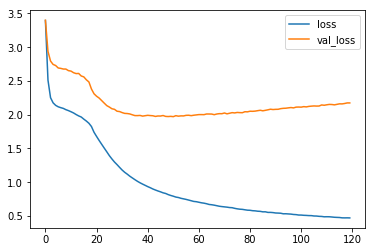

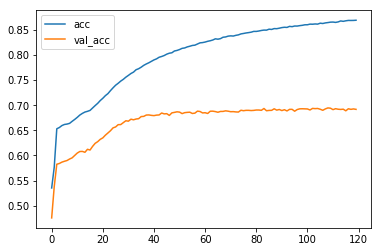

In [150]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## 5 Construct Inference/Prediction Model

### 5.1 Inference Encoder Model

In [151]:
### prediction encoder model
inference_encoder_model = Model(encoder_inputs_placeholder, encoder_lstm_outputs)
inference_encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, 9)                 0         
_________________________________________________________________
encoder_embed (Embedding)    (None, 9, 50)             178550    
_________________________________________________________________
encoder_bidirectional_lstm ( (None, 9, 384)            373248    
Total params: 551,798
Trainable params: 551,798
Non-trainable params: 0
_________________________________________________________________


### 5.2 Inference Decoder Model

In [152]:
# encoder_outputs_as_input is used to compute Attention
encoder_outputs_as_input = Input(shape=(max_len_input, latent_dim * 2))

# decoder_inputs_single is the previous predicted word index
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# IMPORTANT:
# combine context with last word
context = one_time_step_attention(encoder_outputs_as_input, s0)
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s0, c0])
decoder_outputs = decoder_dense(o)

inference_decoder_model = Model(inputs=[decoder_inputs_single, 
                                        encoder_outputs_as_input, 
                                        s0, c0], 
                                outputs=[decoder_outputs, s, c])

In [154]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_chn = {v:k for k, v in word2idx_outputs.items()}

In [155]:
def decode_sequence(input_seq):
    
    # encoder model predict states based on the source sequence (i.e., English)
    #  - The states can be treated as the information representation of this source sequence
    encoder_outputs = inference_encoder_model.predict(input_seq)
    
    # The first input to the LSTM
    pred_seq = np.zeros((1,1))
    pred_seq[0,0] = word2idx_outputs['S']
    
#     pred_seq = np.array([[word2index['<sos>']]])
        
    eos = word2idx_outputs['E']
    
    # [s, c] will be updated in each loop iteration
    s = np.zeros((1, latent_dim))
    c = np.zeros((1, latent_dim))
    
    output_sentence = []
    
    # for each time step of the source sequence
    for _ in range(max_len_target):
        
        # decoder model predicts the output, hidden state and cell state based on 
        # the predicted (single) word (represented by index), hidden state and cell state from previous time step
        o, s, c = inference_decoder_model.predict([pred_seq, encoder_outputs, s, c])
        
        # the output o has shape of (batch_size, word_number)
        # But it actually has only 1 batch and 1 sequence length. It looks like:
        # [[0.1, 0.2, 0.3, 0.3, 0.1]]
        # We only need the probability distribution over all words
        probs = o[0, :]
        
        # greedy way to find current most likely word
        #  - NOTE: a more robust way is to use Beam Search
        idx = np.argmax(probs)
        
        # If the predicted index is the 'end of sequence', the translation process is completed
        if eos == idx:
            break
        
        # Constructing the output sentence
        word = ''
        if idx > 0:
            word = idx2word_chn[idx]
            output_sentence.append(word)
        
        # Set the input for the next time step
        pred_seq[0,0] = idx
        
    return ' '.join(output_sentence)

## 6. Inferencing

In [220]:
# Do some test translations
i = np.random.choice(len(input_texts))
encode_inputs
input_seq = encode_inputs[i:i+1]
print(input_seq.shape)
translation = decode_sequence(input_seq)
print('-')
print('Input:', input_texts[i])
print('Translation:', translation)

(1, 9)
-
Input: I am playing the piano now.
Translation: 我 现 正 彈 琴 。
